In [14]:
from jaxosqp import osqp
import jax
import jax.numpy as jnp
from jax import random

from jax.experimental import sparse

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Generate some random problem data.
B = 100
n = 100
m = 10*n

outer = lambda A: A @ A.T + 1e-2 * sparse.eye(n)
key = random.PRNGKey(208)
key, subkey = random.split(key)
P = sparse.random_bcoo(key, (B, n, n), nse=0.15, n_batch=1, generator=random.normal)
P = jax.vmap(outer)(P).todense() # Ensure P >= 0.

key, subkey = random.split(key)
q = random.normal(subkey, (B, n))
key, subkey = random.split(key)

# Add some random constraints (a la OSQP benchmarks
A = sparse.random_bcoo(subkey, (B, m, n), nse=0.15, n_batch=1, generator=random.normal).todense()
key, subkey = random.split(key)
l = -random.uniform(subkey, (B, m))
key, subkey = random.split(key)
u = random.uniform(subkey, (B, m))

prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
state = prob.step(data, state)

2023-05-23 12:46:54.023444: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB (rounded to 3600000256)requested by op 
2023-05-23 12:46:54.023551: W external/tsl/tsl/framework/bfc_allocator.cc:497] ************************************************************************************________________
2023-05-23 12:46:54.023629: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2469] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3600000160 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.68GiB
              constant allocation:         1B
        maybe_live_out allocation:    2.72GiB
     preallocated temp allocation:    3.35GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    7.75GiB
              total fragmentation:  214.58MiB (2.70%)
Peak buffers:
	Buffer 1:
		Size: 1.68GiB
		

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3600000160 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.68GiB
              constant allocation:         1B
        maybe_live_out allocation:    2.72GiB
     preallocated temp allocation:    3.35GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    7.75GiB
              total fragmentation:  214.58MiB (2.70%)
Peak buffers:
	Buffer 1:
		Size: 1.68GiB
		Entry Parameter Subshape: s32[100,2250000,2]
		==========================

	Buffer 2:
		Size: 1.68GiB
		XLA Label: fusion
		Shape: s32[100,2250000,2]
		==========================

	Buffer 3:
		Size: 858.31MiB
		Operator: op_name="jit(_unique_sorted_mask)/jit(main)/jit(lexsort)/sort[dimension=1 is_stable=True num_keys=2]" source_file="/tmp/ipykernel_568016/825966277.py" source_line=6
		XLA Label: sort
		Shape: s32[100,2250000]
		==========================

	Buffer 4:
		Size: 858.31MiB
		Operator: op_name="jit(_unique_sorted_mask)/jit(main)/jit(lexsort)/sort[dimension=1 is_stable=True num_keys=2]" source_file="/tmp/ipykernel_568016/825966277.py" source_line=6
		XLA Label: sort
		Shape: s32[100,2250000]
		==========================

	Buffer 5:
		Size: 858.31MiB
		Operator: op_name="jit(_unique_sorted_mask)/jit(main)/jit(lexsort)/broadcast_in_dim[shape=(100, 2250000) broadcast_dimensions=(1,)]" source_file="/tmp/ipykernel_568016/825966277.py" source_line=6
		XLA Label: iota
		Shape: s32[100,2250000]
		==========================

	Buffer 6:
		Size: 858.31MiB
		XLA Label: fusion
		Shape: s32[100,2250000]
		==========================

	Buffer 7:
		Size: 858.31MiB
		Operator: op_name="jit(_unique_sorted_mask)/jit(main)/jit(lexsort)/sort[dimension=1 is_stable=True num_keys=2]" source_file="/tmp/ipykernel_568016/825966277.py" source_line=6
		XLA Label: sort
		Shape: s32[100,2250000]
		==========================

	Buffer 8:
		Size: 214.58MiB
		Operator: op_name="jit(_unique_sorted_mask)/jit(main)/scatter[update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(), scatter_dims_to_operand_dims=(1,)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.FILL_OR_DROP]" source_file="/tmp/ipykernel_568016/825966277.py" source_line=6
		XLA Label: pad
		Shape: pred[100,2250000]
		==========================

	Buffer 9:
		Size: 32B
		Operator: op_name="jit(_unique_sorted_mask)/jit(main)/jit(lexsort)/sort[dimension=1 is_stable=True num_keys=2]" source_file="/tmp/ipykernel_568016/825966277.py" source_line=6
		XLA Label: sort
		Shape: (s32[100,2250000], s32[100,2250000], s32[100,2250000], s32[100,2250000])
		==========================

	Buffer 10:
		Size: 24B
		XLA Label: tuple
		Shape: (s32[100,2250000,2], pred[100,2250000], s32[100,2250000])
		==========================

	Buffer 11:
		Size: 16B
		XLA Label: fusion
		Shape: (s32[100,2250000], s32[100,2250000])
		==========================

	Buffer 12:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================

	Buffer 13:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================

	Buffer 14:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================

	Buffer 15:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================



In [27]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
def solve(prob, data, state):
    for ii in range(100):
        data, state = prob.step(data, state)
        
    return data, state

%timeit solve(prob, data, state)

TypeError: cannot unpack non-iterable OSQPState object

Text(0, 0.5, 'solve time (batch of 100), ms')

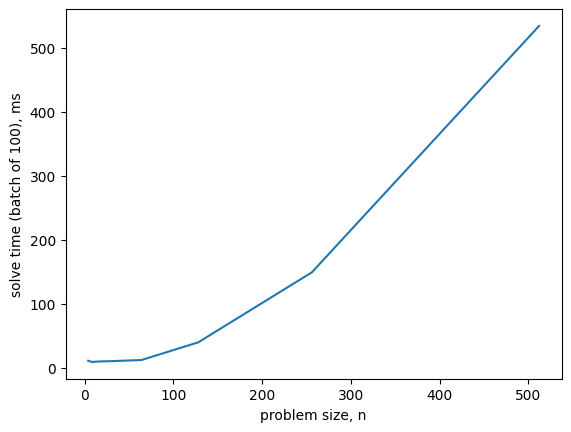

In [35]:
n_vals = [4, 8, 16, 32, 64, 128, 256, 512]
times = [10.9, 9.01, 9.7, 10.3, 12, 39.6, 149, 534]

from matplotlib import pyplot as plt

plt.plot(n_vals, times)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('problem size, n')
plt.ylabel('solve time (batch of 100), ms')

In [20]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
state = prob.solve(data, state)

In [28]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
%time state = prob.solve(data, state)

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.06 s


In [29]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
%time state = prob.solve(data, state)

CPU times: user 652 ms, sys: 274 µs, total: 652 ms
Wall time: 652 ms


In [162]:
A = sparse.random_bcoo(key, (5, 2, 2), nse=0.15, n_batch=1, generator=random.normal)
sum_x = jax.vmap(sparse.sparsify(lambda x: jnp.sum(x @ x.T + sparse.eye(2))))

sum_x(A)

Array([2.005999 , 2.1144671, 2.004582 , 2.5526845, 2.1723697], dtype=float32)